#  Стохастические градиентные методы

## Постановка задачи

$$
\min_x \frac1N \sum_{i=1}^N f_i(x)
$$

- Целевая функция - сумма конечного числа функций
- $N$ может быть очень большим

### Особенности задачи

- Точное вычисление градиента занимает очень много времени
- Высокая точность решения обычно не требуется
- Допустимо введение случайности

## Использование структуры функции

- Так как целевая функция равна сумме функций, то градиент равен сумме градиентов
- **Основная идея:** вместо сложения всех градиентов, сложить только некоторые, выбранные некотором образом
- Как выбирать?

## Стохастический градиентный спуск (SGD)

$$
x_{k+1} = x_k - \alpha_k \sum_{i \in \mathcal{I}} f'_i(x_k)
$$

Сходимость

- Для выпуклых функций $\mathcal{O}(1 / \sqrt{k})$
- Для сильно выпуклых функций $\mathcal{O}(1 / k)$

## Ускоренный градиентный метод

$$
\begin{align*}
& h_k = \beta h_{k-1} - \alpha_k \sum_{i\in \mathcal{I}} f'_i(x_k + \alpha_k h_k)\\
& x_{k+1} = x_k + h_k
\end{align*}
$$

- Не приводит к ускорению в теории!
- Почему?
- Различные реализации в различных пакетах могут называться одинаково

## Adagrad

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = r + g_k \cdot g_k\\
& h_k = -\frac{\varepsilon}{\delta + \sqrt{r}} \cdot g_k\\
& x_{k+1} = x_k + h_k
\end{align*}

- Диагональное шкалирование градиента
- Учёт **всей** предыдущей истории для вычисления следующей точки
- Не улучшает теоретические оценки сходимости

## Adam

\begin{align*}
& g_k = \sum_{i \in \mathcal{I}} f'_i(x_k)\\
& r = \rho_2r + (1 - \rho_2) g_k \cdot g_k\\
& s = \rho_1 s + (1 - \rho_1) g_k\\
& \hat{s} = \frac{s}{1 - \rho_1^k}\\
& \hat{r} = \frac{r}{1 - \rho_2^k}\\
& h_k = -\frac{\varepsilon \hat{s}}{\delta + \sqrt{\hat{r}}} \\
& x_{k+1} = x_k + h_k
\end{align*}

- Все операции выполняются поэлементно

## Другие модификации

<img src="optax_common.png" width=400>

- Список взят из документации к [optax](https://optax.readthedocs.io/en/latest/)
- Как вы думаете, что можно улучшать в рассмотренных выше методах?

## Основные направления улучшений

- Настройка размера шага
- Использование дополнительного шума для избегания локальных минимумов
- Сокращение дополнительной памяти

In [207]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
%matplotlib inline

import optax

num_parameters = 100
X = jax.random.normal(jax.random.PRNGKey(0), (1000, num_parameters))
w_true = jax.random.normal(jax.random.PRNGKey(0), (num_parameters,))
y = X @ w_true + 0.01 * jax.random.normal(jax.random.PRNGKey(0), (1,))

def f_(x, params):
    w = params["weight"]
    return x @ w

f = jax.vmap(f_, (0, None), 0)

def loss(params, x, y):
    y_hat = f(x, params)
    diff = y - y_hat
    return jnp.mean(jnp.square(diff))


grad_f = jax.grad(loss, argnums=0)
init_params = {"weight": jax.random.normal(jax.random.PRNGKey(10), (num_parameters,))}
lr = 1e-2
sgd = optax.sgd(learning_rate=lr)
acc_sgd = optax.sgd(learning_rate=lr, momentum=0.9)
acc_nesterov_sgd = optax.sgd(learning_rate=lr, momentum=0.9, nesterov=True)
adam = optax.adam(learning_rate=lr)

batch_size = 100
num_epochs = 100

In [208]:
def fit(params, optimizer, X, y, key, conv):
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    num_samples = X.shape[0]
    num_iter = num_samples // batch_size
    idxs = jax.random.permutation(key, num_samples)
    for i in range(num_iter):
        params, opt_state, loss_value = step(params, opt_state,
                                             X[idxs[batch_size*i:batch_size*(i+1)]],
                                             y[idxs[batch_size*i:batch_size*(i+1)]])
        conv.append(loss_value)

    return params

In [209]:
import copy
key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, sgd, X, y, key, conv)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_acc = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, acc_sgd, X, y, key, conv_acc)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_acc_nesterov = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, acc_nesterov_sgd, X, y, key, conv_acc_nesterov)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_adam = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, adam, X, y, key, conv_adam)

Text(0.5, 1.0, 'Batch size = 100, lr = 0.01')

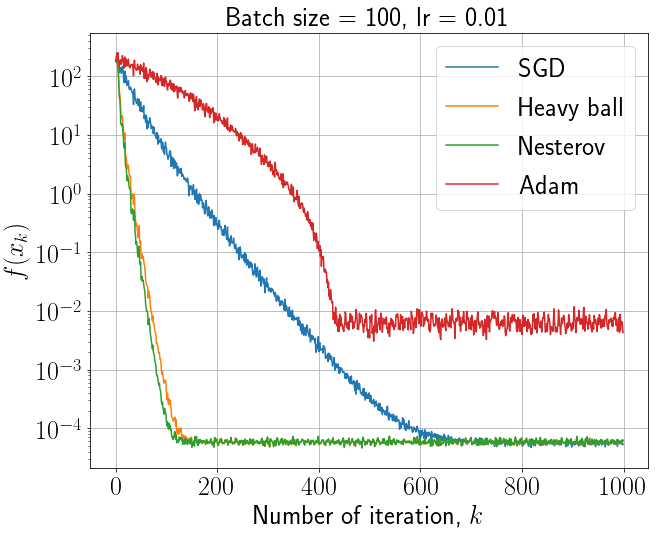

In [210]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.semilogy(conv, label="SGD")
plt.semilogy(conv_acc, label="Heavy ball")
plt.semilogy(conv_acc_nesterov, label="Nesterov")
plt.semilogy(conv_adam, label="Adam")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)
plt.title("Batch size = {}, lr = {}".format(batch_size, lr), fontsize=fontsize)

In [213]:
batch_size = 2
num_epochs = 4

lr = 1e-3
sgd = optax.sgd(learning_rate=lr)
acc_sgd = optax.sgd(learning_rate=lr, momentum=0.9)
acc_nesterov_sgd = optax.sgd(learning_rate=lr, momentum=0.9, nesterov=True)
adam = optax.adam(learning_rate=lr)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, sgd, X, y, key, conv)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_acc = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, acc_sgd, X, y, key, conv_acc)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_acc_nesterov = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, acc_nesterov_sgd, X, y, key, conv_acc_nesterov)

key = jax.random.PRNGKey(0)
params = copy.deepcopy(init_params)
conv_adam = []
for k in range(num_epochs):
    key, subkey = jax.random.split(key)
    params =  fit(params, adam, X, y, key, conv_adam)

Text(0.5, 1.0, 'Batch size = 2, lr = 0.001')

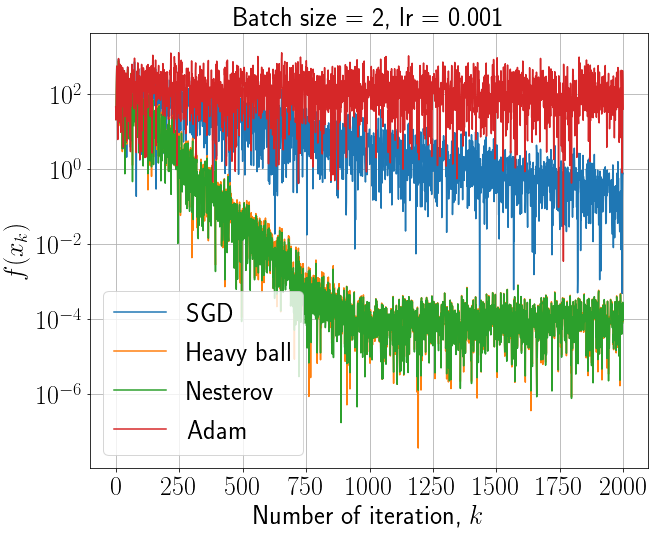

In [214]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.semilogy(conv, label="SGD")
plt.semilogy(conv_acc, label="Heavy ball")
plt.semilogy(conv_acc_nesterov, label="Nesterov")
plt.semilogy(conv_adam, label="Adam")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)
plt.title("Batch size = {}, lr = {}".format(batch_size, lr), fontsize=fontsize)

## Выводы

- Использование знания о структуре функции позволяет ускорить процесс вычисления градиента
- За это приходится платить снижением точности
- Адаптивные размеры шага генерируются на основании истории вычисленных градиентов
- Иногда адекватно работают и для невыпуклых функций
- Ускоренные методы работают на практике гораздо лучше, чем в теории